**importing libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

**reading data and EDA**

In [2]:
train_data = pd.read_csv('train_data.txt',sep=':::',names=['ID','TITLE','GENRE','DESCRIPTION'],engine='python')

In [3]:
train_data

,ID,TITLE,GENRE,DESCRIPTION
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...
...,...,...,...,...
54209,54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...
54210,54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...
54211,54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g..."
54212,54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           54214 non-null  int64 
 1   TITLE        54214 non-null  object
 2   GENRE        54214 non-null  object
 3   DESCRIPTION  54214 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


In [5]:
train_data.describe()

,ID
count,54214.000000
mean,27107.500000
std,15650.378084
min,1.000000
25%,13554.250000
50%,27107.500000
75%,40660.750000
max,54214.000000


In [6]:
train_data.isnull().sum()

ID             0
TITLE          0
GENRE          0
DESCRIPTION    0
dtype: int64

In [7]:
test_data = pd.read_csv('test_data.txt',sep=':::',names=['ID','TITLE','DESCRIPTION'],engine='python')

In [8]:
test_data

,ID,TITLE,DESCRIPTION
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...
...,...,...,...
54195,54196,"""Tales of Light & Dark"" (2013)","Covering multiple genres, Tales of Light & Da..."
54196,54197,Der letzte Mohikaner (1965),As Alice and Cora Munro attempt to find their...
54197,54198,Oliver Twink (2007),A movie 169 years in the making. Oliver Twist...
54198,54199,Slipstream (1973),"Popular, but mysterious rock D.J Mike Mallard..."


In [9]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54200 entries, 0 to 54199
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           54200 non-null  int64 
 1   TITLE        54200 non-null  object
 2   DESCRIPTION  54200 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [10]:
test_data.describe()

,ID
count,54200.000000
mean,27100.500000
std,15646.336632
min,1.000000
25%,13550.750000
50%,27100.500000
75%,40650.250000
max,54200.000000


In [11]:
test_data.isnull().sum()

ID             0
TITLE          0
DESCRIPTION    0
dtype: int64

**Visualizing the distribution of genre**

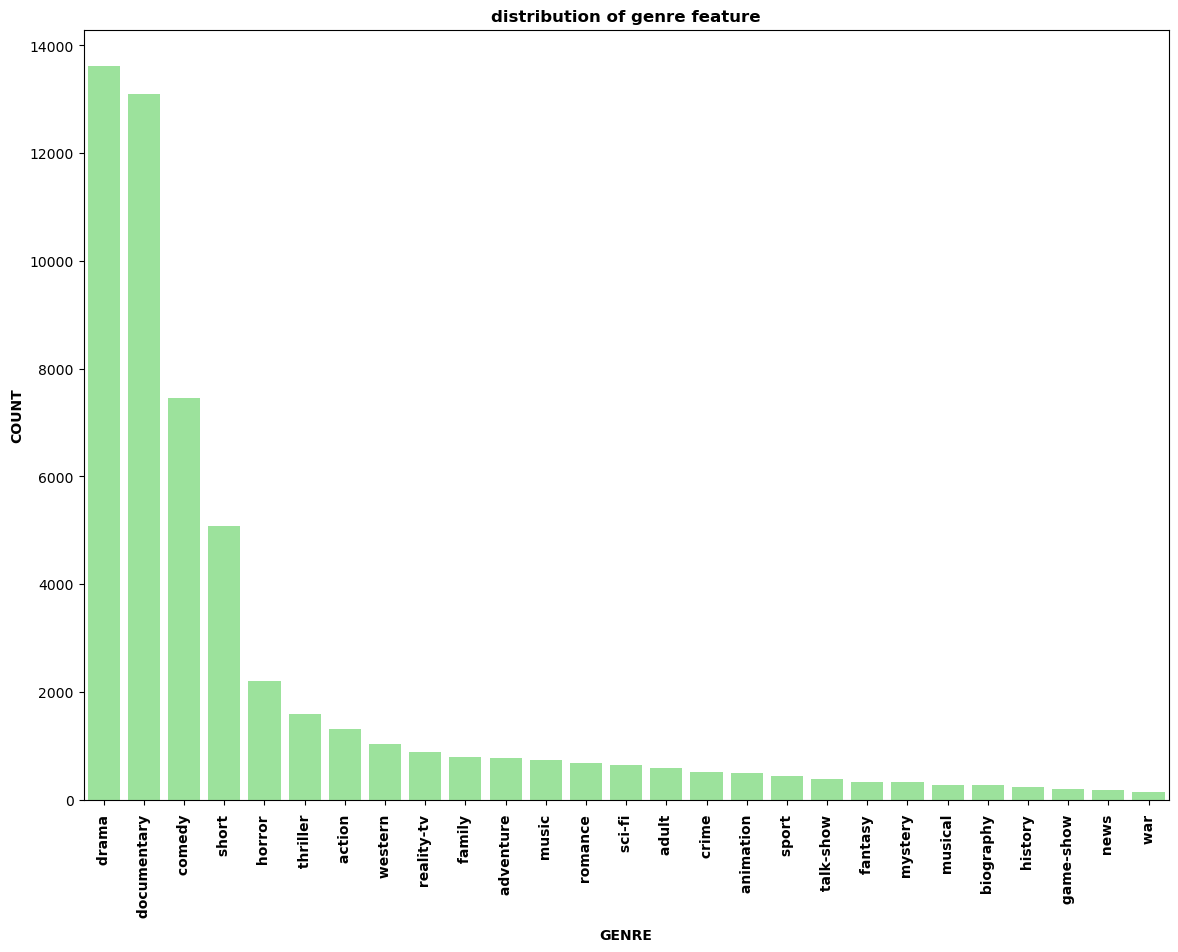

In [12]:
plt.figure(figsize=(14,10))
val_counts=train_data['GENRE'].value_counts()
sns.barplot(x=val_counts.index,y=val_counts,color='lightgreen')
plt.xlabel("GENRE",fontweight='bold')
plt.ylabel("COUNT",fontweight='bold')
plt.title("distribution of genre feature",fontweight='bold')
plt.xticks(rotation=90,fontweight='bold');

Text(0, 0.5, 'GENRE')

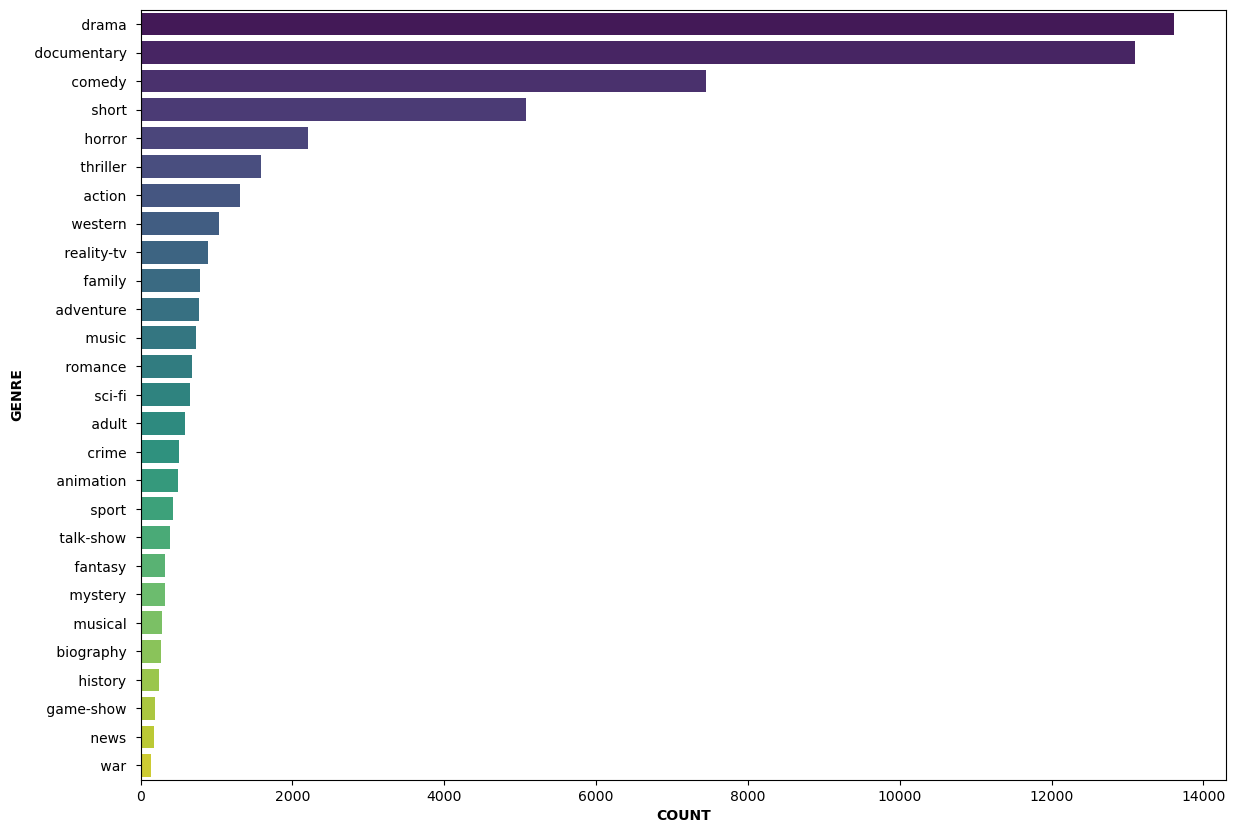

In [13]:
plt.figure(figsize=(14,10))
sns.countplot(data=train_data,y='GENRE',order=train_data['GENRE'].value_counts().index,palette='viridis')
plt.xlabel('COUNT',fontweight='bold')
plt.ylabel('GENRE',fontweight='bold')

In [14]:
stemmer = LancasterStemmer()
stopwords=set(stopwords.words('english'))

**data preprocessing**

In [15]:
def text_cleaning(data):
    data=data.lower()
    data = re.sub(r'@\S+', '', data)
    data = re.sub(r'http\S+', '', data)
    data = re.sub(r'pic.\S+', '', data)
    data = re.sub(r"[^a-zA-Z+']", ' ', data)
    data =re.sub(r'\s+[a-zA-Z]\s+', ' ', data + ' ')
    data = "".join([i for i in data if i not in string.punctuation])
    words = nltk.word_tokenize(data)
    data = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    data = re.sub("\s[\s]+", " ", data).strip()
    return data

In [16]:
train_data['Cleaned_Des']=train_data['DESCRIPTION'].apply(text_cleaning)
test_data['Cleaned_Des']=test_data['DESCRIPTION'].apply(text_cleaning)

In [17]:
train_data

,ID,TITLE,GENRE,DESCRIPTION,Cleaned_Des
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening conversation doctor parents year old...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bus empties students field trip museum natural...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemployed father make ends meet edith tw...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,films title refers recovered bodies ground zer...
...,...,...,...,...,...
54209,54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...,short lived nbc live sitcom centered bonino wo...
54210,54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...,next generation exploitation sisters kapa bay ...
54211,54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g...",bestaan echt stand comedy growing facing fears...
54212,54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...,walter vivian live country difficult time keep...


In [18]:
print("shape before droping duplicates",train_data.shape)
train_data = train_data.drop_duplicates()
print("shape after droping duplicates",train_data.shape)

shape before droping duplicates (54214, 5)
shape after droping duplicates (54214, 5)


**Visualizing the preprocessed description and its length**

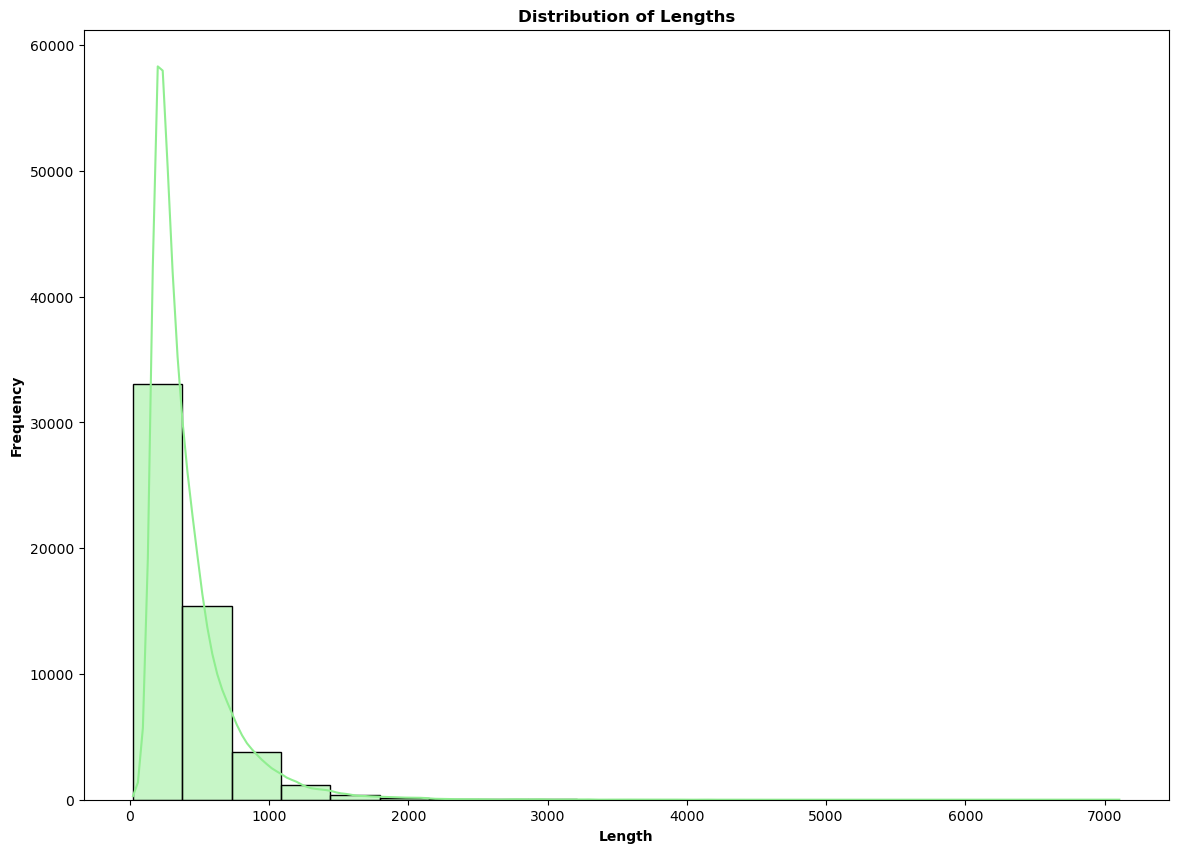

In [19]:
train_data['length_CleanDes'] = train_data['Cleaned_Des'].apply(len)
plt.figure(figsize=(14, 10))
sns.histplot(data=train_data, x='length_CleanDes', bins=20, kde=True, color='lightgreen')
plt.xlabel('Length',fontweight='bold')
plt.ylabel('Frequency',fontweight='bold')
plt.title('Distribution of Lengths',fontweight='bold')
plt.show()

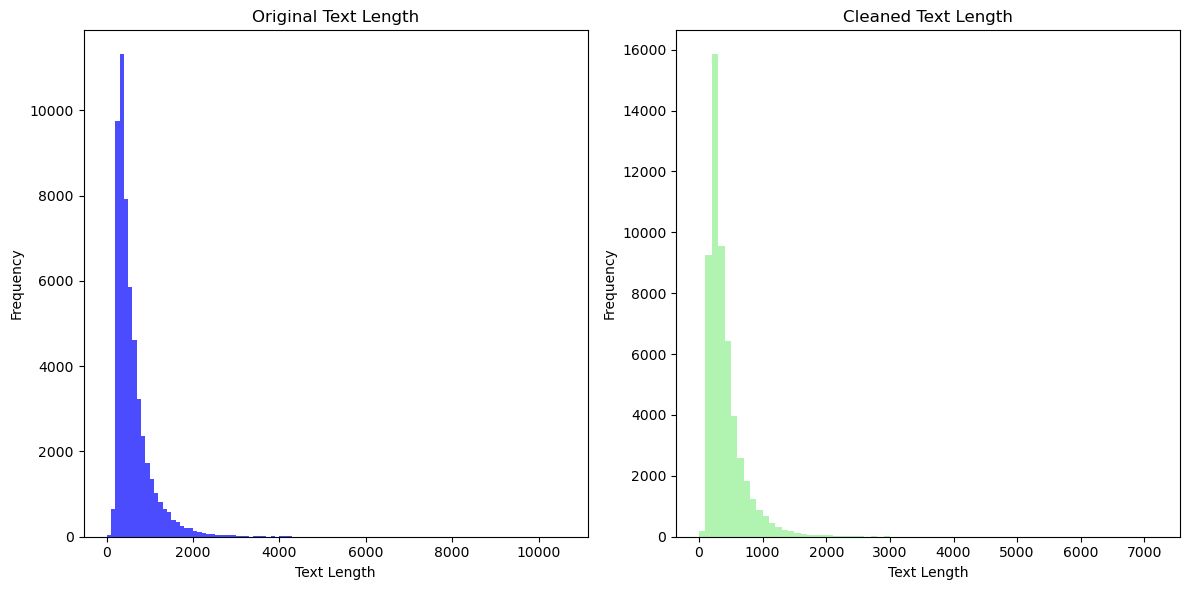

In [20]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
original_lengths = train_data['DESCRIPTION'].apply(len)
plt.hist(original_lengths, bins=range(0, max(original_lengths) + 100, 100), color='blue', alpha=0.7)
plt.title('Original Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
cleaned_lengths=train_data['Cleaned_Des'].apply(len)
plt.hist(cleaned_lengths, bins=range(0, max(cleaned_lengths) + 100, 100), color='lightgreen', alpha=0.7)
plt.title('Cleaned Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

**Encoding the target genre and splitting the data before word embeddings**

In [21]:
label_encoder = LabelEncoder()
train_data['Genre_encoded'] = label_encoder.fit_transform(train_data['GENRE'])
class_names= list(label_encoder.classes_)
class_names

[' action ',
 ' adult ',
 ' adventure ',
 ' animation ',
 ' biography ',
 ' comedy ',
 ' crime ',
 ' documentary ',
 ' drama ',
 ' family ',
 ' fantasy ',
 ' game-show ',
 ' history ',
 ' horror ',
 ' music ',
 ' musical ',
 ' mystery ',
 ' news ',
 ' reality-tv ',
 ' romance ',
 ' sci-fi ',
 ' short ',
 ' sport ',
 ' talk-show ',
 ' thriller ',
 ' war ',
 ' western ']

In [22]:
train_data['Genre_encoded']

0         8
1        24
2         1
3         8
4         8
         ..
54209     5
54210    13
54211     7
54212     5
54213    12
Name: Genre_encoded, Length: 54214, dtype: int32

In [23]:
x = train_data['Cleaned_Des']
y = train_data['Genre_encoded']
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.2,random_state=42)

 # using TFIDF Vectorizer

**using three different classifiers for this method**

In [24]:
tfidf = TfidfVectorizer()
x_tf_train = tfidf.fit_transform(x_train)
x_tf_test = tfidf.transform(test_data['Cleaned_Des'])
x_tf_val = tfidf.transform(x_val)

In [25]:
classifier1=MultinomialNB()
classifier1.fit(x_tf_train,y_train)

MultinomialNB()

In [26]:
y_pred = classifier1.predict(x_tf_val)

In [27]:
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.4465553813520243


In [28]:
print(classification_report(y_val, y_pred,zero_division=1))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00       263
           1       1.00      0.00      0.00       112
           2       1.00      0.00      0.00       139
           3       1.00      0.00      0.00       104
           4       1.00      0.00      0.00        61
           5       0.73      0.04      0.08      1443
           6       1.00      0.00      0.00       107
           7       0.54      0.90      0.67      2659
           8       0.38      0.88      0.53      2697
           9       1.00      0.00      0.00       150
          10       1.00      0.00      0.00        74
          11       1.00      0.00      0.00        40
          12       1.00      0.00      0.00        45
          13       1.00      0.00      0.00       431
          14       1.00      0.00      0.00       144
          15       1.00      0.00      0.00        50
          16       1.00      0.00      0.00        56
          17       1.00    

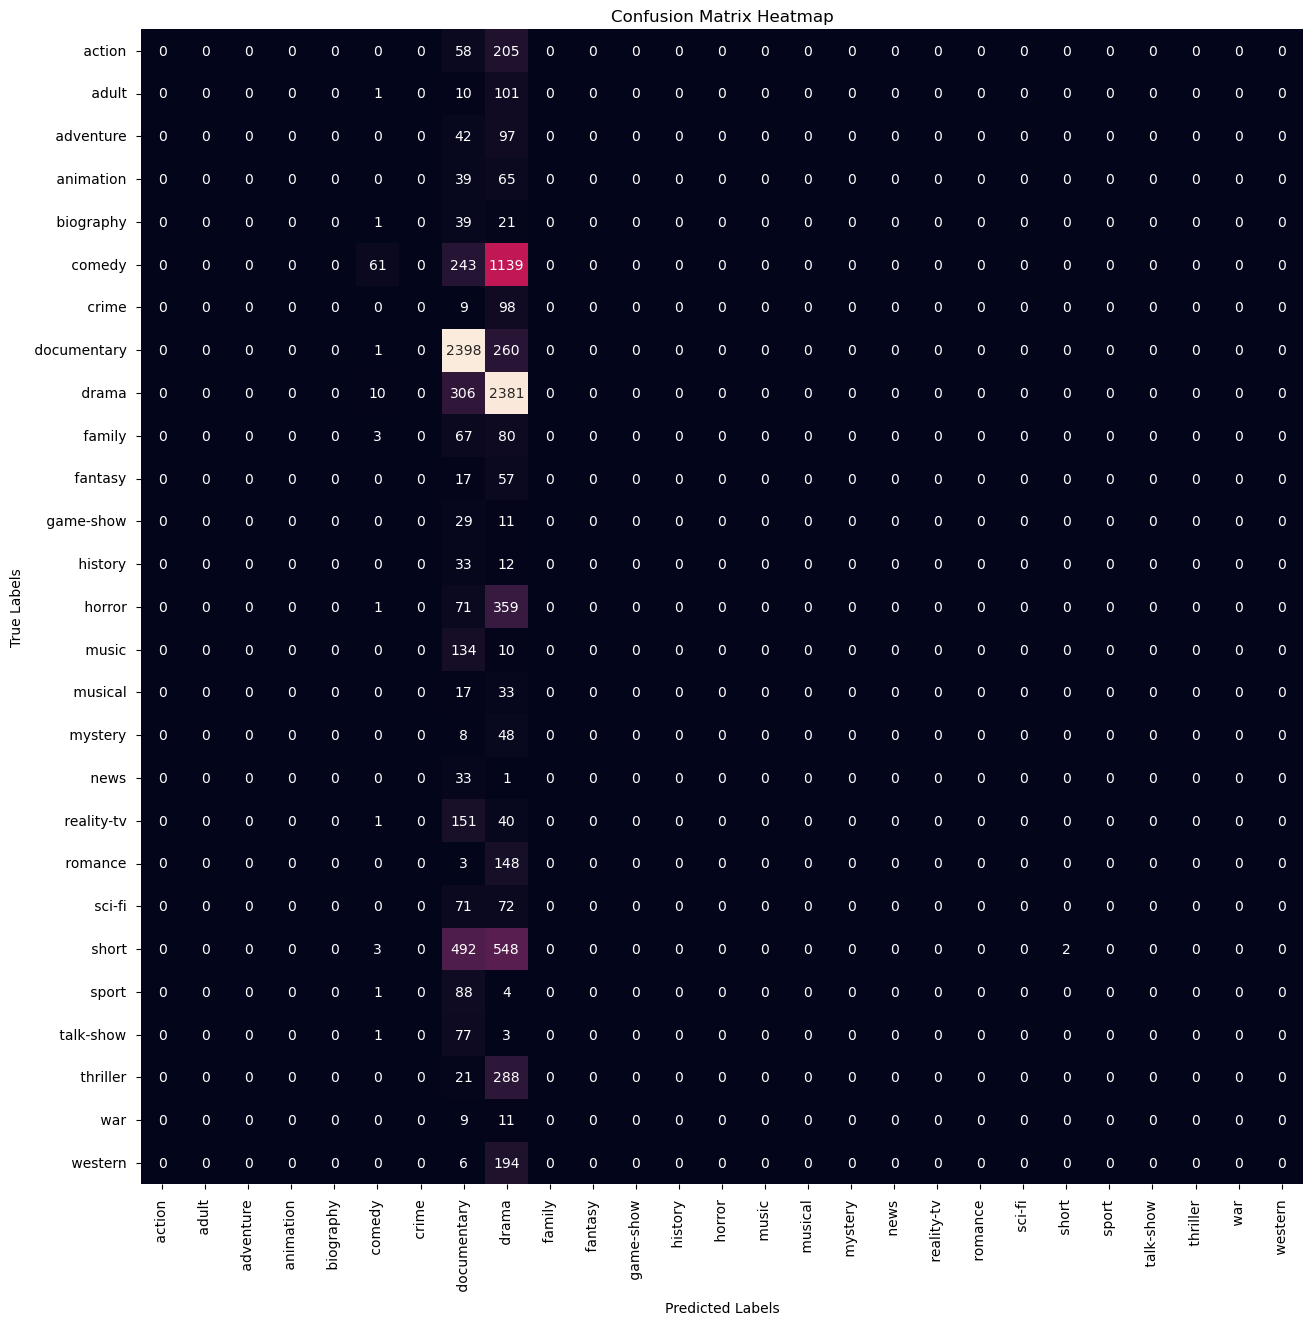

In [29]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [30]:
classifier2 = LogisticRegression()
classifier2.fit(x_tf_train,y_train)

C:\Users\guhan\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [31]:
y_pred1 = classifier2.predict(x_tf_val)

In [32]:
accuracy = accuracy_score(y_val, y_pred1)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.5801899843216822


In [33]:
print(classification_report(y_val, y_pred1,zero_division=1))

              precision    recall  f1-score   support

           0       0.56      0.22      0.32       263
           1       0.82      0.21      0.33       112
           2       0.47      0.12      0.18       139
           3       0.67      0.02      0.04       104
           4       1.00      0.00      0.00        61
           5       0.52      0.60      0.56      1443
           6       0.33      0.01      0.02       107
           7       0.64      0.87      0.74      2659
           8       0.54      0.80      0.64      2697
           9       0.47      0.05      0.10       150
          10       1.00      0.00      0.00        74
          11       0.92      0.30      0.45        40
          12       1.00      0.00      0.00        45
          13       0.68      0.56      0.61       431
          14       0.70      0.33      0.45       144
          15       1.00      0.00      0.00        50
          16       1.00      0.00      0.00        56
          17       1.00    

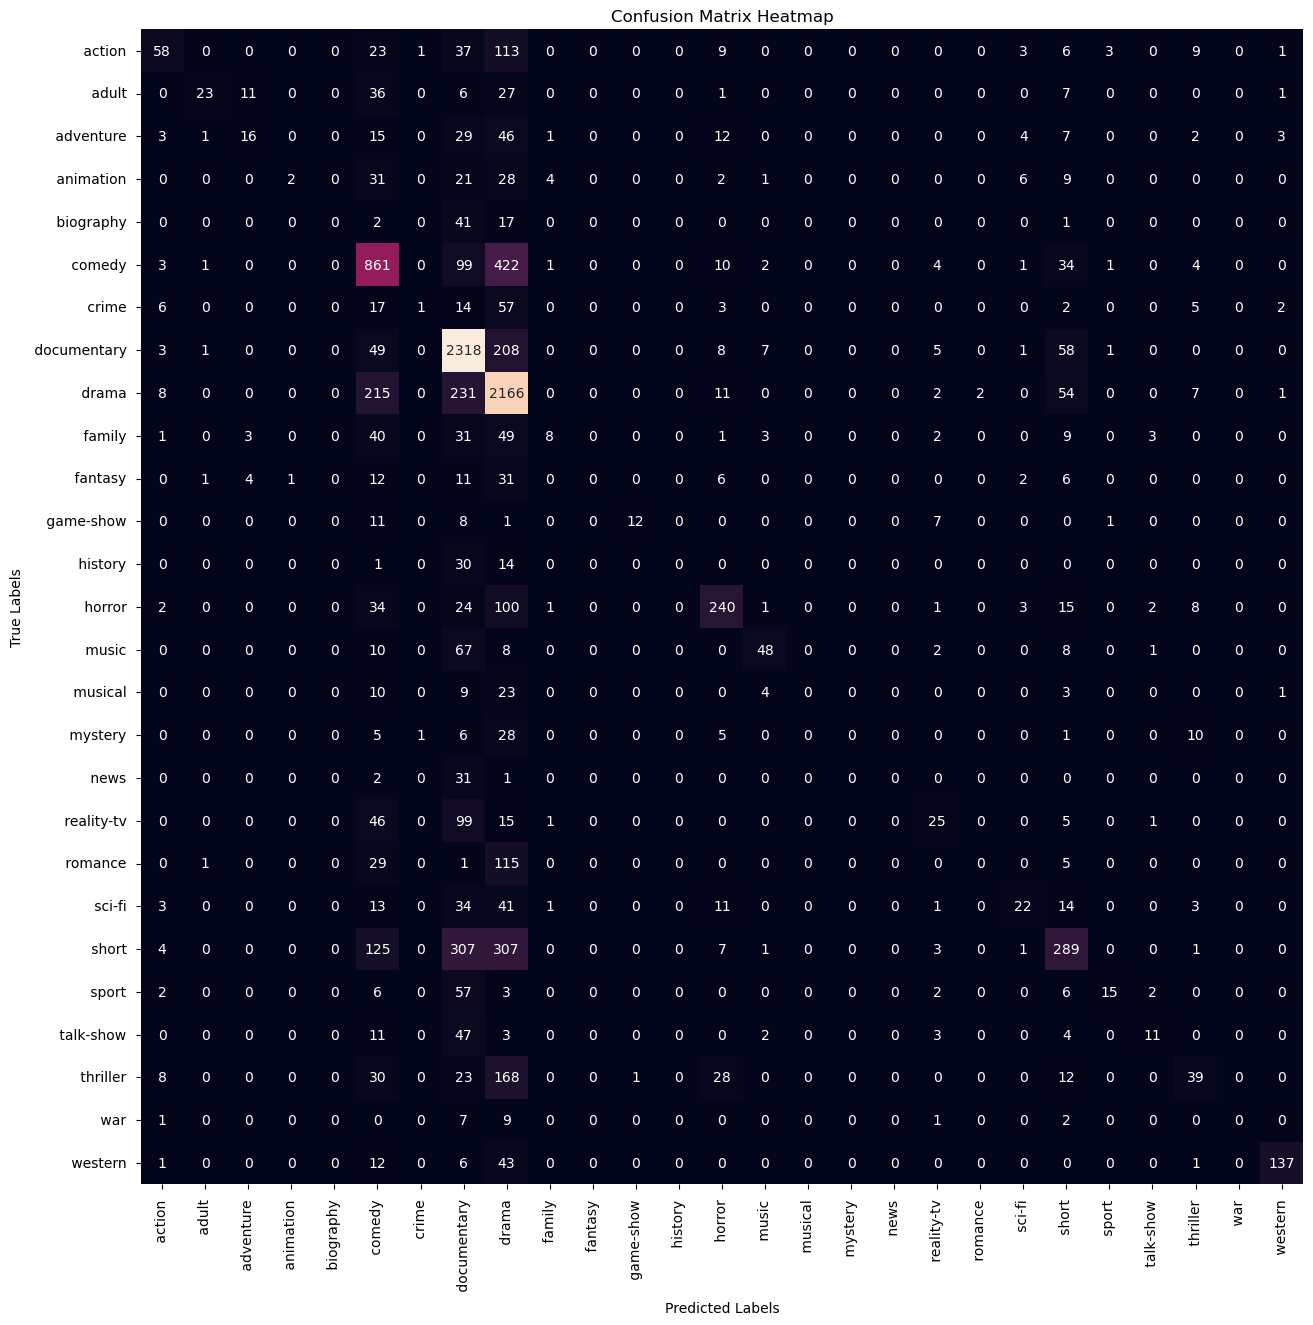

In [34]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred1)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [35]:
classifier3 = LinearSVC()
classifier3.fit(x_tf_train,y_train)

C:\Users\guhan\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

In [36]:
y_pred2 = classifier3.predict(x_tf_val)

In [37]:
accuracy = accuracy_score(y_val, y_pred2)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.5884902702204187


In [38]:
print(classification_report(y_val, y_pred2,zero_division=1))

              precision    recall  f1-score   support

           0       0.47      0.35      0.40       263
           1       0.75      0.45      0.56       112
           2       0.48      0.23      0.31       139
           3       0.38      0.12      0.18       104
           4       0.00      0.00      1.00        61
           5       0.53      0.59      0.56      1443
           6       0.29      0.07      0.11       107
           7       0.69      0.83      0.75      2659
           8       0.57      0.73      0.64      2697
           9       0.37      0.17      0.24       150
          10       0.07      0.01      0.02        74
          11       0.82      0.68      0.74        40
          12       0.50      0.02      0.04        45
          13       0.65      0.67      0.66       431
          14       0.62      0.58      0.60       144
          15       0.43      0.06      0.11        50
          16       0.25      0.02      0.03        56
          17       0.22    

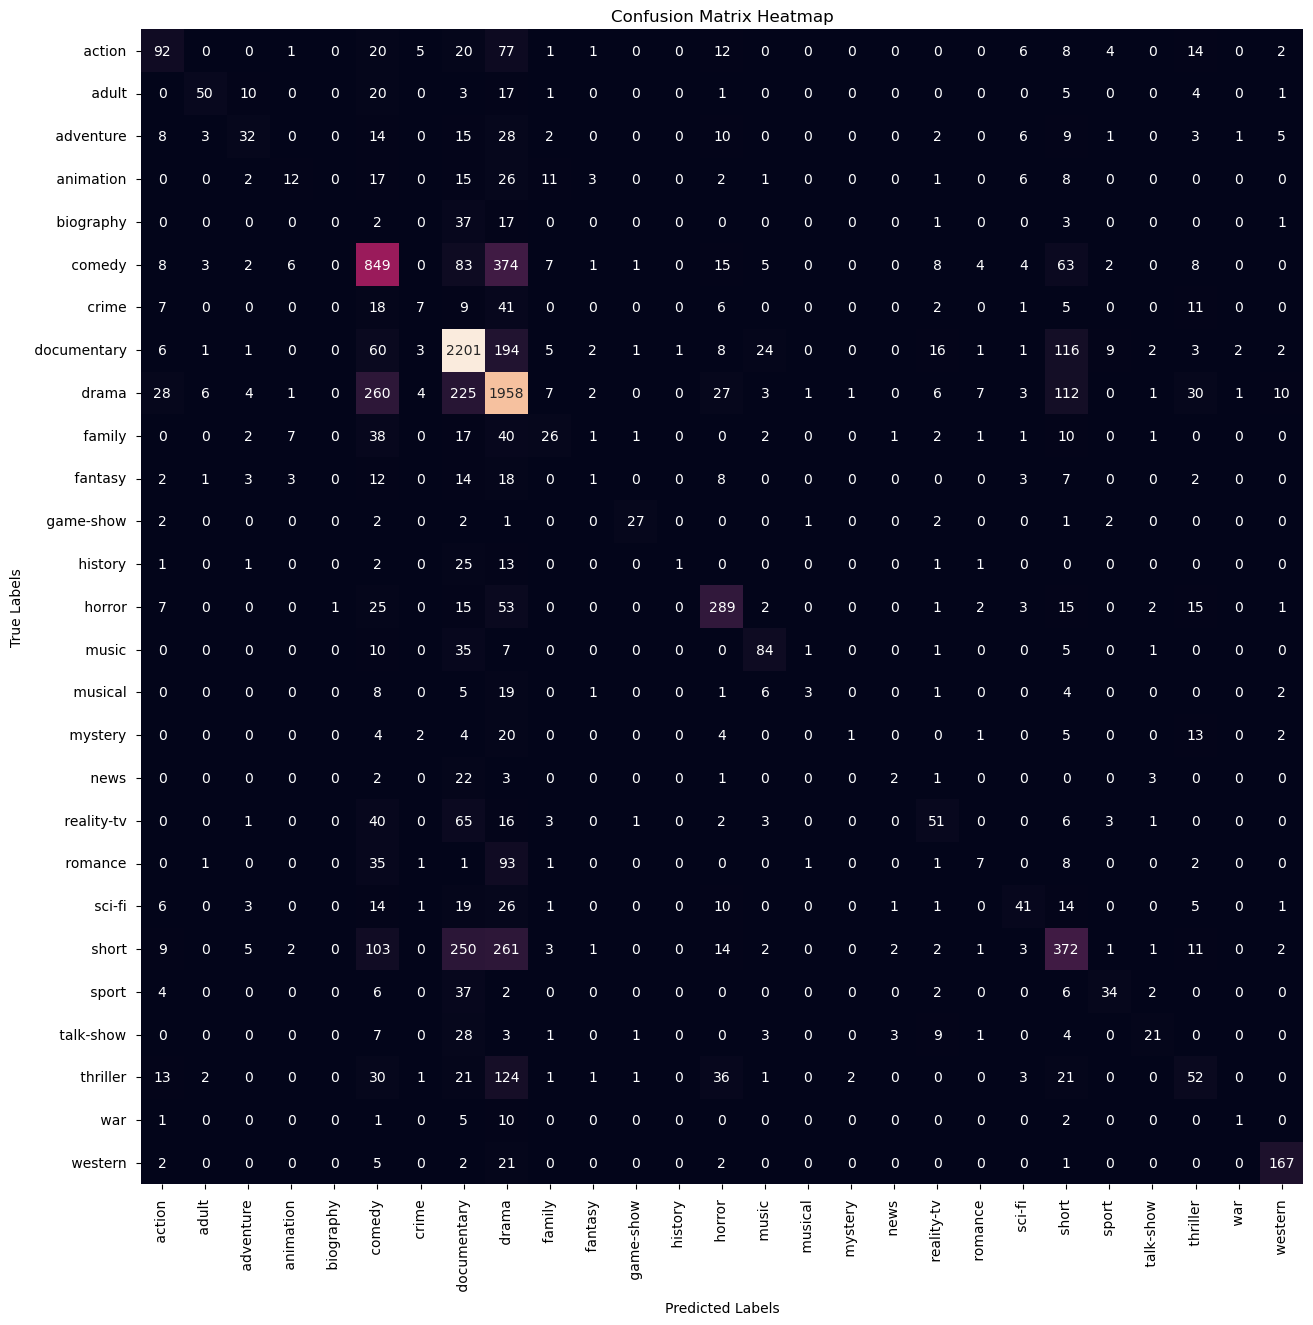

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred2)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

# using CountVectorizer

**using three different classifiers for this method**

In [40]:
cv = CountVectorizer()
x_cv_train = cv.fit_transform(x_train)
x_cv_test =  cv.transform(test_data['Cleaned_Des'])
x_cv_val = cv.transform(x_val)

In [41]:
classifier4=MultinomialNB()
classifier4.fit(x_cv_train,y_train)

MultinomialNB()

In [42]:
y_pred = classifier4.predict(x_cv_val)

In [43]:
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.5290048879461403


In [44]:
print(classification_report(y_val, y_pred,zero_division=1))

              precision    recall  f1-score   support

           0       0.87      0.05      0.09       263
           1       0.62      0.04      0.08       112
           2       0.36      0.06      0.11       139
           3       0.00      0.00      1.00       104
           4       1.00      0.00      0.00        61
           5       0.51      0.47      0.49      1443
           6       0.00      0.00      1.00       107
           7       0.57      0.90      0.70      2659
           8       0.47      0.82      0.60      2697
           9       1.00      0.00      0.00       150
          10       1.00      0.00      0.00        74
          11       1.00      0.10      0.18        40
          12       1.00      0.00      0.00        45
          13       0.74      0.31      0.44       431
          14       0.78      0.10      0.17       144
          15       1.00      0.00      0.00        50
          16       1.00      0.00      0.00        56
          17       1.00    

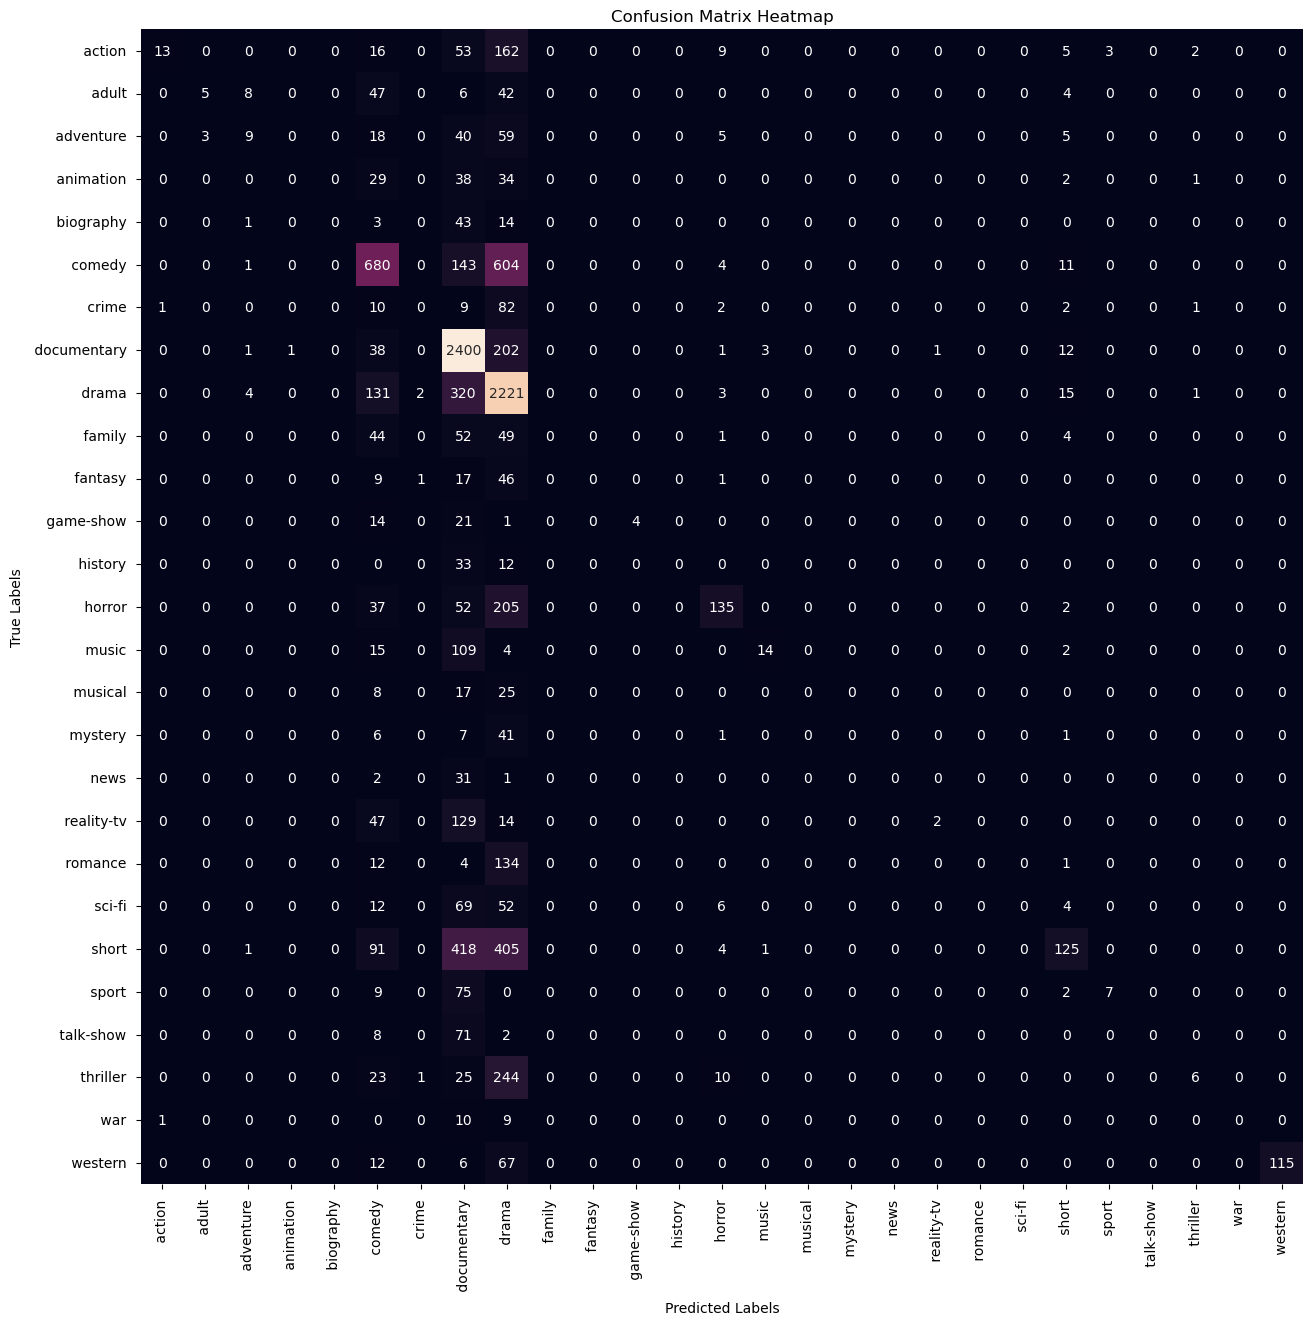

In [45]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [46]:
classifier5 = LogisticRegression()
classifier5.fit(x_cv_train,y_train)

C:\Users\guhan\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [47]:
y_pred1 = classifier5.predict(x_cv_val)

In [48]:
accuracy = accuracy_score(y_val, y_pred1)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.5659872728949553


In [49]:
print(classification_report(y_val, y_pred1,zero_division=1))

              precision    recall  f1-score   support

           0       0.42      0.34      0.37       263
           1       0.71      0.39      0.51       112
           2       0.39      0.24      0.30       139
           3       0.41      0.16      0.23       104
           4       0.00      0.00      1.00        61
           5       0.52      0.58      0.55      1443
           6       0.23      0.09      0.13       107
           7       0.70      0.77      0.74      2659
           8       0.56      0.69      0.62      2697
           9       0.29      0.17      0.22       150
          10       0.17      0.04      0.07        74
          11       0.81      0.62      0.70        40
          12       0.00      0.00      1.00        45
          13       0.63      0.61      0.62       431
          14       0.56      0.53      0.55       144
          15       0.31      0.08      0.13        50
          16       0.19      0.05      0.08        56
          17       0.25    

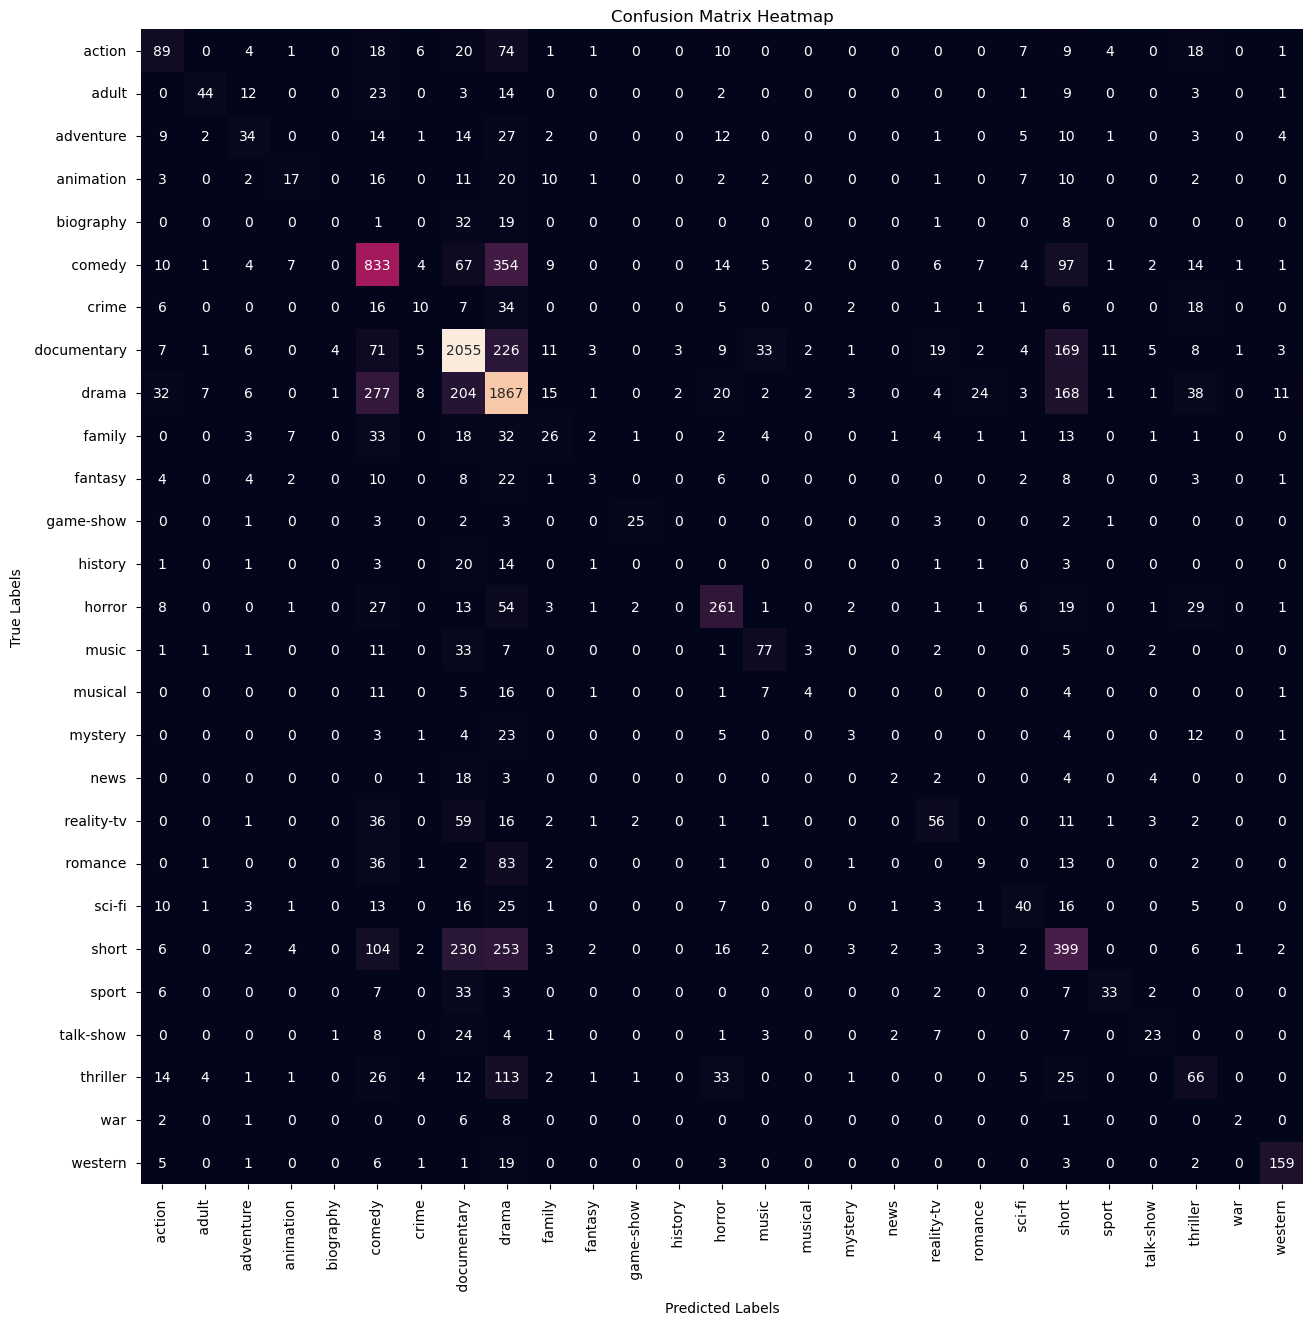

In [50]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred1)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [51]:
classifier6 = LinearSVC()
classifier6.fit(x_cv_train,y_train)

C:\Users\guhan\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\guhan\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [52]:
y_pred2 = classifier6.predict(x_cv_val)

In [53]:
accuracy = accuracy_score(y_val, y_pred2)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.5179378400811584


In [54]:
print(classification_report(y_val, y_pred2,zero_division=1))

              precision    recall  f1-score   support

           0       0.33      0.30      0.31       263
           1       0.54      0.42      0.47       112
           2       0.28      0.24      0.26       139
           3       0.24      0.13      0.17       104
           4       0.00      0.00      1.00        61
           5       0.49      0.53      0.51      1443
           6       0.17      0.08      0.11       107
           7       0.70      0.71      0.70      2659
           8       0.53      0.60      0.57      2697
           9       0.22      0.17      0.19       150
          10       0.09      0.05      0.07        74
          11       0.77      0.60      0.68        40
          12       0.00      0.00      1.00        45
          13       0.58      0.60      0.59       431
          14       0.50      0.51      0.51       144
          15       0.08      0.06      0.07        50
          16       0.07      0.05      0.06        56
          17       0.11    

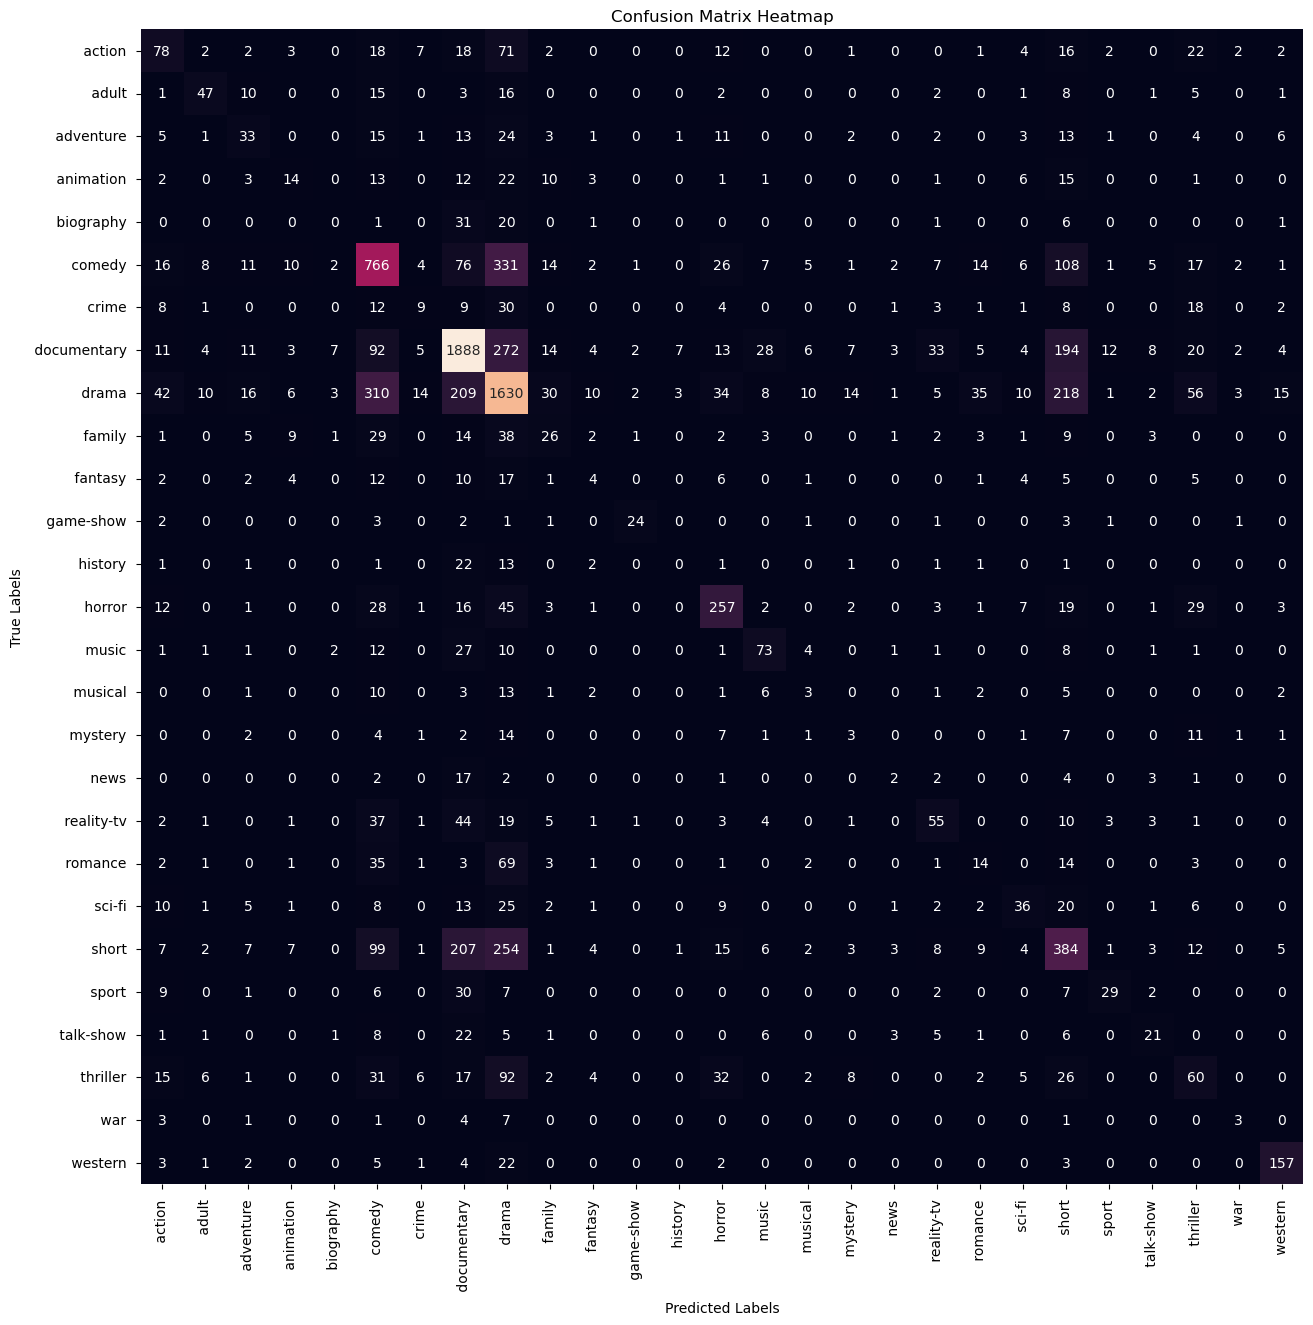

In [55]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred2)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()